- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2020/2021
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 2. Diseño de DSS en Industria 4.0 (Parte 1/3)

En este ejemplo, como continuación del Proyecto 2, vamos a utlizar Python para profundizar en el desarrollo de modelos predictivos que puedan ser usados en una planta de galvanizado de bobinas de acero.

En este proyecto se pretende tener una experiencia cercana a aspectos propios de la Industria 4.0 como el Big Data y la Simulación.

![Industria 4.0](https://blog.wearedrew.co/hubfs/Industria-4-0.gif)

Lógicamente, el proceso de extracción, captura de la información y selección dentro de las miles de variables, ha sido realizado previamente. En nuestro caso, trabajaremos con una base de datos ya reducida y limpia, preparada para un contexto de aprendizaje. Esta Base de Datos está modificada para conservar la confidencialidad con la empresa.

Recordando lo visto en la primera parte de esta práctica, el objetivo consiste en desarrollar modelos que puedan ser utilizados para controlar y optimizar el proceso de recocido de una línea de galvanizado en continuo de bobinas de acero (línea de subida de la curva de recocido).
1. Caso A: Modelos de predicción de la temperatura de consigna del horno en la zona 1 del horno (THC1) según la temperatura de entrada de la banda, la temperatura a la que debe salir la banda, la velocidad de la banda, las dimensiones de la banda de acero y el tipo de acero de la misma.
2. Caso B: Modelo de predicción que permita predecir la temperatura de la banda de acero cuando sale del horno (TMPP2) según las temperaturas del horno (THC1, THC3 y THC5), la temperatura de entrada de la banda de acero (TMPP1), la velocidad de la banda (VELMED), dimensiones y tipo de acero.

![](http://templete.8directo.com/wp-content/uploads/sites/2/2018/02/Acerinox.jpg)

In [ ]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

## Cargamos la Base de Datos

In [ ]:
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff -O DATOS_HORNO_ENTRENA.arff
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_TESTEO.arff -O DATOS_HORNO_TESTEO.arff

--2021-04-29 15:56:31--  https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff [following]
--2021-04-29 15:56:32--  https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125832 (123K) [text/plain]
Saving to: ‘DATOS_HORNO_ENTRENA.arff’

DATOS_HORNO_ENTRENA 100%[===================>] 122.88K  --.-KB/s    in 0.01s   

2021-04-29 15:56:32 (9.64 MB/s) - ‘DATOS_HORNO_ENTRENA.arff’ saved [125832/125832]

--2021-04-29

In [ ]:
# Leemos los archivos arff
df_train = pd.DataFrame(arff.loadarff("DATOS_HORNO_ENTRENA.arff")[0])
df_test = pd.DataFrame(arff.loadarff("DATOS_HORNO_TESTEO.arff")[0])

In [ ]:
df_train.head()

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006.0,b'B011F97',1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007.0,b'B011F97',1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008.0,b'B011F97',1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0
3,23293009.0,b'B011F97',1250.0,0.6,903.0,5330.0,145.0,221.0,755.0,750.0,758.0,788.0,811.0
4,23293010.0,b'B011F97',1250.0,0.6,2540.0,15030.0,105.0,223.0,752.0,750.0,752.0,783.0,806.0


Vemos que al leer nos han incluido un caracter 'b' en el código de la bobina y comillas simples. Procedemos a decodificarlo como formato *utf-8*.mando 'replace'

In [ ]:
# Convertimos la variable CLASACERO a utf-8
df_train['CLASACERO'] = df_train['CLASACERO'].str.decode('utf-8')
df_test['CLASACERO'] = df_test['CLASACERO'].str.decode('utf-8')
df_train.head()

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006.0,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007.0,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008.0,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0
3,23293009.0,B011F97,1250.0,0.6,903.0,5330.0,145.0,221.0,755.0,750.0,758.0,788.0,811.0
4,23293010.0,B011F97,1250.0,0.6,2540.0,15030.0,105.0,223.0,752.0,750.0,752.0,783.0,806.0


La descripción de las variables de la base de datos es la siguiente:

-	CODBOB: Código de la bobina.
-	CLASACERO: Tipo de acero.
-	ANCHO: Ancho medio de la banda de acero. (mm)
-	ESPESOR: Espesor medio de la banda de acero. (mm).
-	LARGO: Largo medio de la banda de acero. (m).
-	PESO: Peso medio de la bobina. (Kg*10).
-	VELMED: Velocidad media de la banda de acero en el horno. (m/min)
-	TMPP1: Temperatura media de la banda de acero a la entrada del horno. (ºC)
-	TMPP2: Temperatura media de la banda de acero a la salida del horno. (ºC)
-	TMPP2CNG: Temperatura media objetivo que debería tener la banda de acero a la salida del horno. (ºC)
-	THC1: Temperatura media de consigna en la zona 1 del Horno. (ºC)
-	THC3: Temperatura media de consigna en la zona 3 del Horno. (ºC).
-	THC5: Temperatura media de consigna en la zona 5 del Horno. (ºC)

En este caso, los valores de temperatura del horno, de la banda de acero y de velocidad de la misma corresponden con los valores medios obtenidos para cada una de las bobinas.


In [ ]:
df_test.head()

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053.0,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054.0,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055.0,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0
3,23633056.0,B105F55,1040.0,0.7,3513.0,19980.0,139.0,263.0,842.0,840.0,854.0,884.0,906.0
4,23643001.0,B100F55,1062.0,0.7,2949.0,17050.0,139.0,253.0,829.0,825.0,847.0,877.0,895.0


In [ ]:
np.unique(df_train['CLASACERO'])

array(['B011B99', 'B011F97', 'B012B97', 'B012F53', 'B012F55', 'B013B55',
       'B013C55', 'B014F53', 'B016F35', 'B023H53', 'B025F55', 'B032H53',
       'B042H53', 'B044H53', 'B081B99', 'B085F97', 'B085G99', 'B100B95',
       'B100F33', 'B100F55', 'B101F55', 'B102G33', 'B102G55', 'B103G33',
       'B103G55', 'B105F55', 'B120G55', 'C107G55', 'C114G55', 'C115G55',
       'C116G55', 'D012F55', 'D012G99', 'D031B33', 'D032F55', 'D071F55',
       'D094B33', 'D094G55', 'K011B55', 'K011F57', 'K021H43', 'K021H53',
       'K022H53', 'N013H53', 'N017B97', 'X100G99'], dtype=object)

También convertimos el código de la bobina a entero.

In [ ]:
df_train['CODBOB'] = df_train['CODBOB'].astype(int)
df_test['CODBOB'] = df_test['CODBOB'].astype(int)

display(df_train.head(3), df_test.head(3))

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0


,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0


In [ ]:
df_train.shape, df_test.shape #Tamaño final de las bases de datos

((1898, 13), (81, 13))

## Análisis Exploratorio de Datos

In [ ]:
df_train.describe() # Describe variables numéricas

,CODBOB,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
count,1.898000e+03,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000
mean,2.346880e+07,1175.884615,0.888298,2392.461538,17488.838778,108.591675,249.407798,807.407798,806.642782,815.469442,845.613277,865.016860
std,9.847295e+04,197.816664,0.348482,1044.062929,5014.451152,46.984315,19.790073,32.183468,32.415592,37.621038,38.236909,39.908894
min,2.329301e+07,750.000000,0.430000,350.000000,1380.000000,30.000000,200.000000,715.000000,725.000000,702.000000,734.000000,734.000000
25%,2.338304e+07,1000.000000,0.650000,1631.250000,14140.000000,87.000000,234.000000,790.000000,783.000000,795.000000,825.000000,840.000000
50%,2.346307e+07,1220.000000,0.770000,2186.500000,18695.000000,113.000000,250.000000,821.000000,825.000000,824.500000,854.000000,874.000000
75%,2.355304e+07,1301.000000,1.170000,3102.750000,21380.000000,125.000000,265.000000,826.000000,825.000000,844.000000,875.000000,894.000000
max,2.363305e+07,1525.000000,2.000000,5538.000000,26340.000000,999.000000,300.000000,867.000000,861.000000,877.000000,907.000000,932.000000


Vamos a ver la distribución de los datos para identificar valores anómalos

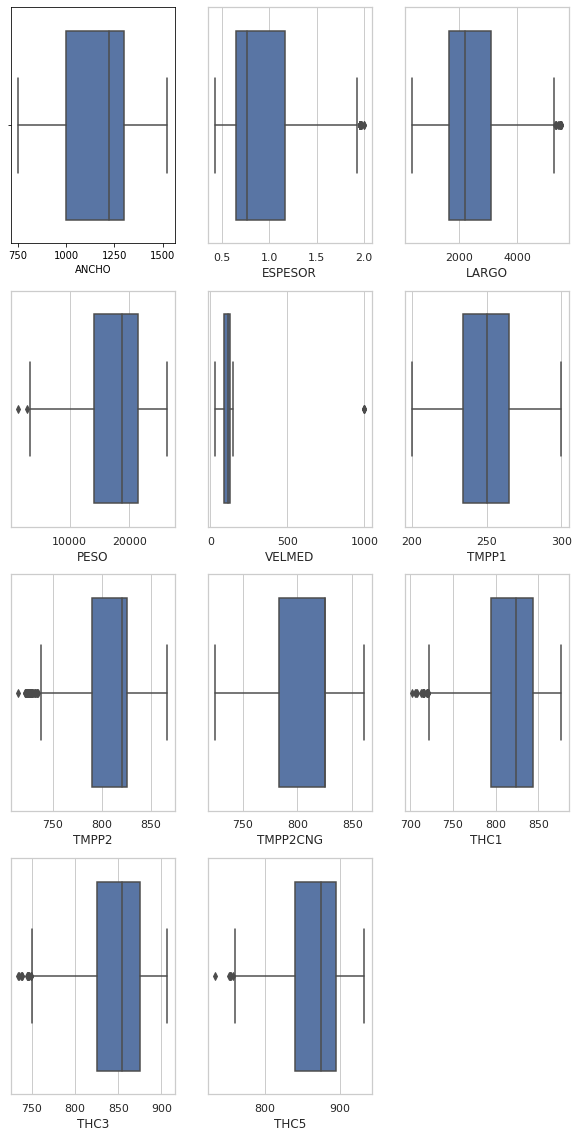

In [ ]:
# %config InlineBackend.figure_format = 'svg' # formato vectorial
fig = plt.figure(figsize=(10,20))
for ncol, columna in enumerate(df_train.columns[2:]):
    plt.subplot(4,3,ncol+1)
    sns.set(style="whitegrid")
    ax = sns.boxplot(x=df_train[columna], data=df_train)

Vemos algo extraño en la variable VELMED. Vamos a ver cuantos casos hay mayores de 500 metros por minuto y los eliminamos de la base de datos porque el proceso no permite velocidades de banda tan altas.

In [ ]:
np.sum(df_train['VELMED']>500)

4

In [ ]:
df_train = df_train.loc[df_train['VELMED']<500] # Nos quedamos con los casos menores de 500

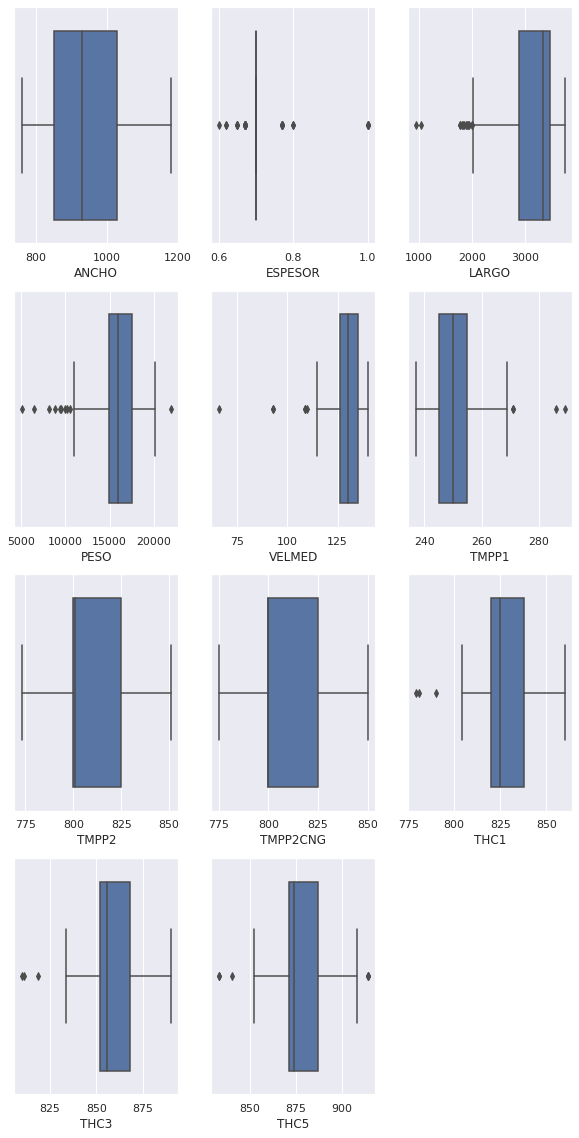

In [ ]:
# %config InlineBackend.figure_format = 'svg' # formato vectorial
sns.set(style="darkgrid")
fig = plt.figure(figsize=(10,20))
for ncol, columna in enumerate(df_test.columns[2:]):
    plt.subplot(4,3,ncol+1)
    ax = sns.boxplot(x=df_test[columna], data=df_train)

**EJERCICIO: Analiza los diagramas de cajas de las celdas anteriores y escribe tus conclusiones. Incluye el codigo que consideres necesario para justificar las mismas.**

Antes de cualquier análisis vamosa echar un vistazo a valores espúreos, los que se alejan de la meda, más que dos veces la desviación típica.

In [ ]:
df_test.head()
var_list=["CODBOB","CLASACERO","ANCHO","ESPESOR","LARGO","PESO","VELMED","TMPP1","TMPP2","TMPP2CNG","THC1","THC3","THC5"]

VARIABLE: ANCHO


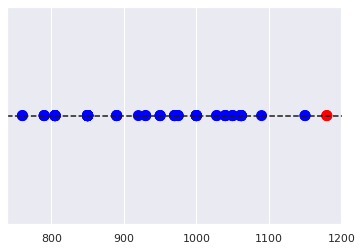

VARIABLE: ESPESOR


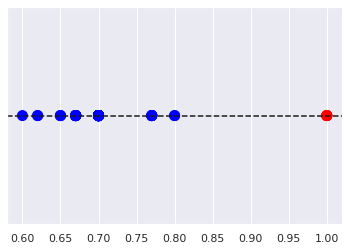

VARIABLE: LARGO


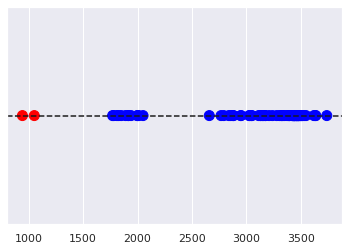

VARIABLE: PESO


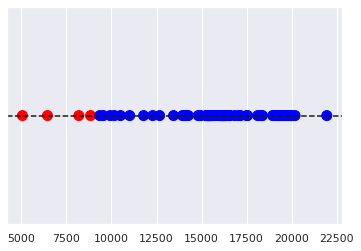

VARIABLE: VELMED


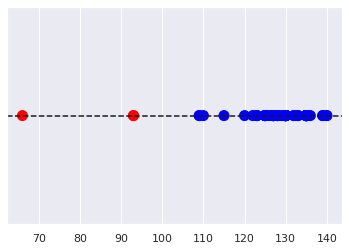

VARIABLE: TMPP1


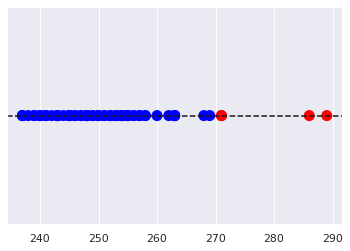

VARIABLE: TMPP2


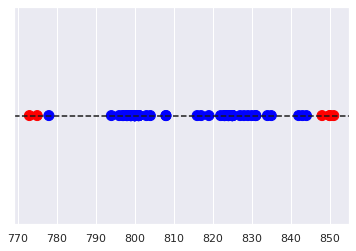

VARIABLE: TMPP2CNG


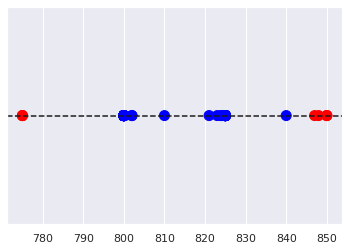

VARIABLE: THC1


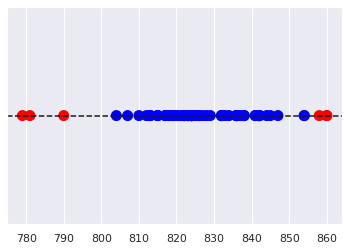

VARIABLE: THC3


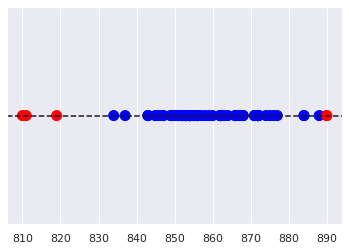

VARIABLE: THC5


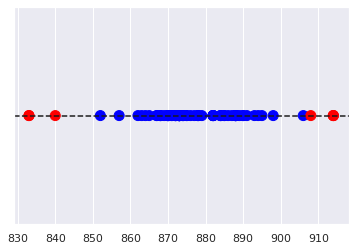

In [ ]:
for i in range(2,len(var_list)):
  var =  df_test[var_list[i]]
  var_unique, counts = np.unique(var, return_counts=True)
  media = var.mean()
  std_x = var.std()*2
  sizes = counts*100
  colors = ['blue']*len(var)
  for index, x in enumerate(var):
    if abs(x-media) > std_x:
        colors[index] = 'red'
  
  plt.axhline(1, color='k', linestyle='--')
  plt.scatter(var,np.ones(len(var)), s=100, color=colors)
  plt.yticks([])
  print("===================================")
  print("VARIABLE: "+var_list[i])
  plt.show()


Variable ESPESOR, como vemos salvo contados casos la inmensa mayoria tienen un espesor muy proximo, marcando un unico caso anómalo donde tiene un espesor de 1.

Si vemos las temperaturas (THC1,THC3,THC5,TMPP2CNG,TMPP1 y TMPP2), vemos que todas todas sus muestras similares, debido a que todo ocurre dentro del horno.

Respecto a otros valores como la velocidad vemos que mas al menos todas las velocidades estan recogidas entre valores muy similares, lo ocurre en genenral con las varibles, siendo ANCHO segun el diagrama la que mas varía (aunque sea valores muy pequeños).

La base de datos de testeo aparentemente no tiene casos anómalos. Ahora, vamos a dibujar algunas variables.

In [ ]:
def dibuja_proceso(df, pos_ini = 0, num_bobs = None):
    if num_bobs==None:
        num_bobs = len(df)
    # Dibuja Espesor y Ancho con dos ejes
    # -----------------------------------
    df_plot = df.iloc[pos_ini:pos_ini+num_bobs]

    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
    ax.plot(df_plot['ESPESOR'], label='ESPESOR')
    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Espesor (mm.)')
    # Segundo eje
    ax.plot(df_plot['ANCHO']/1000.0, label='ANCHO')
    def CtoF(x):
        return x * 1000.0
    def FtoC(x):
        return x / 1000.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Ancho (mm.)')
    ax.legend()

    # Dibuja Temperaturas y Velocidad con dos ejes
    # -----------------------------------
    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))
    for colname in df_plot.columns[7:]:
        ax.plot(df_plot[colname], label=colname)

    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Temperaturas (ºC)')

    ax.plot(df_plot['VELMED']*3.0, label='VELMED')
    def CtoF(x):
        return x / 3.0
    def FtoC(x):
        return x * 3.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Velocidad Media (m/min)')
    ax.legend()


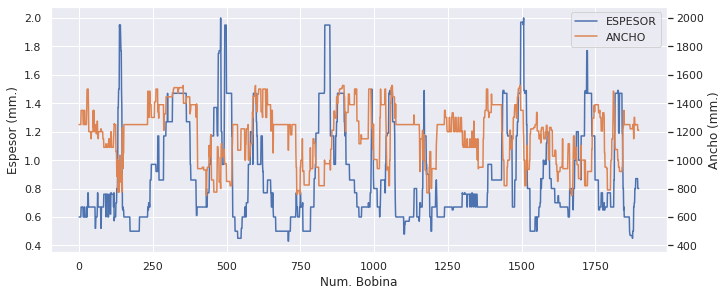

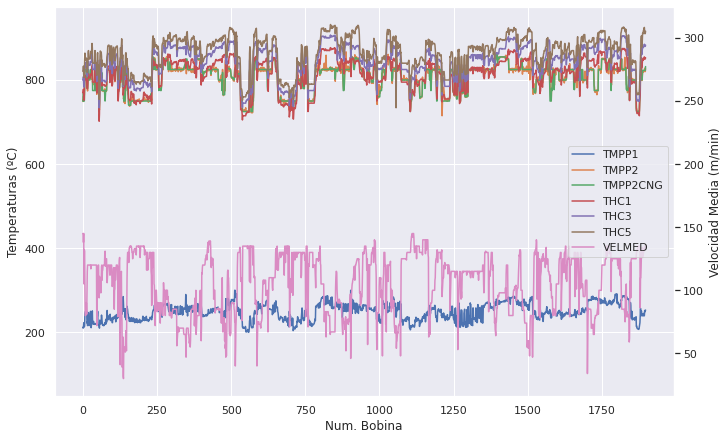

In [ ]:
dibuja_proceso(df_train)

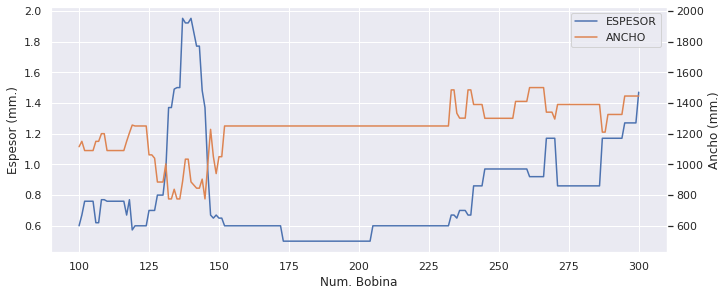

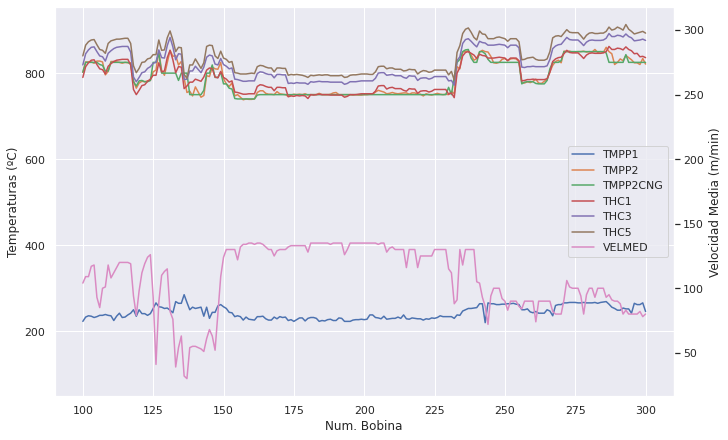

In [ ]:
dibuja_proceso(df_train, pos_ini=100, num_bobs=200)

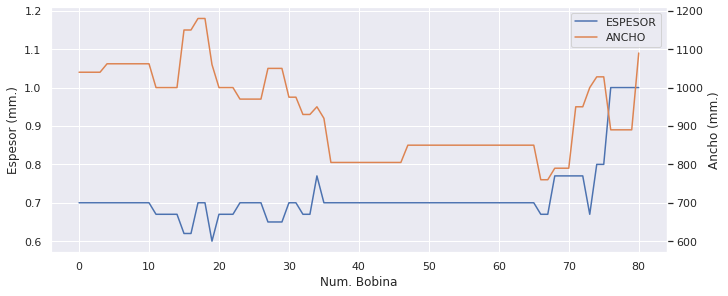

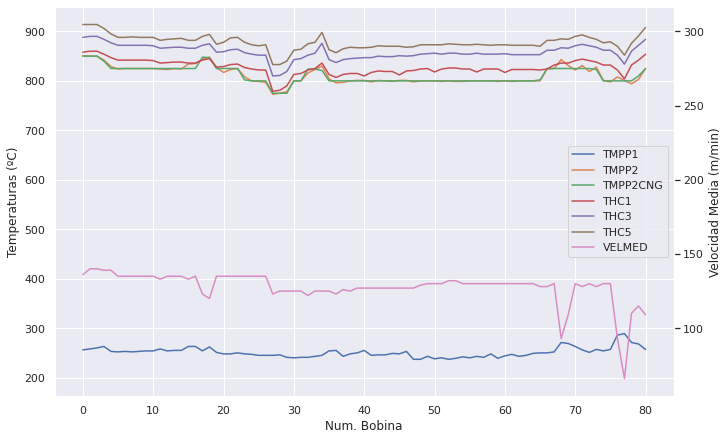

In [ ]:
dibuja_proceso(df_test)

**EJERCICIO: Usando las funciones anteriores, visualiza tres momentos donde se produzcan cambios bruscos de velocidad y escribe tus conclusiones. Incluye el codigo que consideres necesario para justificar las mismas.**

El primer momento que visualizo es el pico hacia abajo que hay antes de la bobina numero 70, donde baja drásticamente y vuelve a la normalidad.
Esto se repite en la bobina 80, donde hay otro gran pico hacia abajo ya la hora de legar a la bobina 80 se vuelve a normalizar.

Qué ocurre con estos dos momentos, si nos fijamos arriba en la linea del espesor, vemos que coinciden con un aumento del espesor, entonces en el momento dónde aumenta, es donde mas se resiente la velocidad.

Los representaremos a continuación.

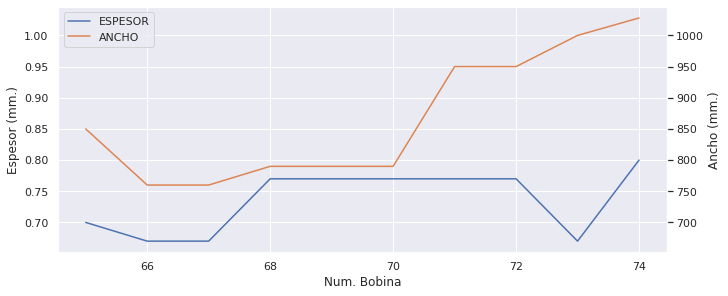

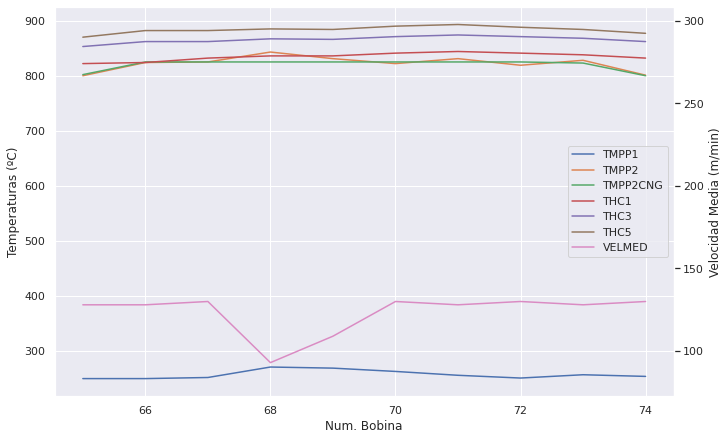

In [ ]:
#el primero descrito
dibuja_proceso(df_test,pos_ini=65, num_bobs=10)

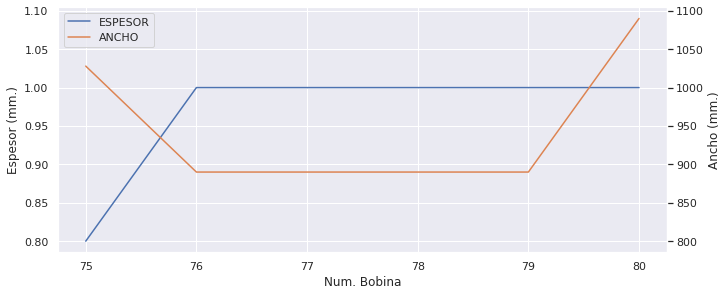

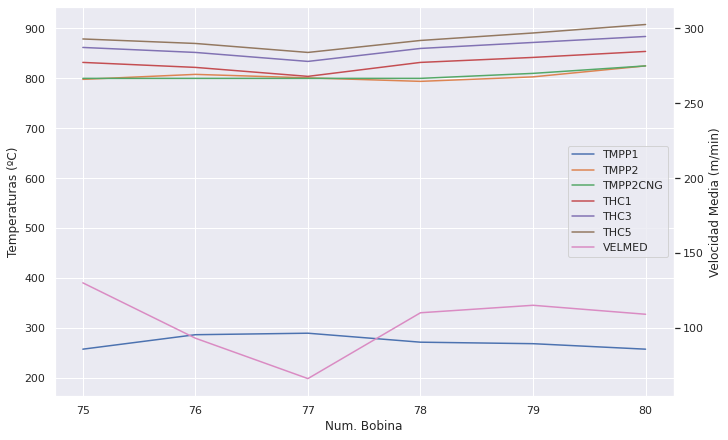

In [ ]:
#el primero descrito
dibuja_proceso(df_test,pos_ini=75, num_bobs=10)

Aqui podemos tomas nuestro tercer momento, en este casosi vemos en la bobina numero 130 desciende bruscamente mientras aumenta, pero si vemos en los momentos donde se vuelve a mantener la velocidad aumenta, por lo que solo picos cuando se aumenta, durante el cambio.

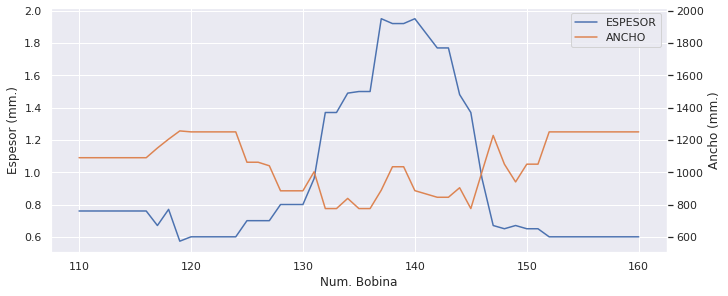

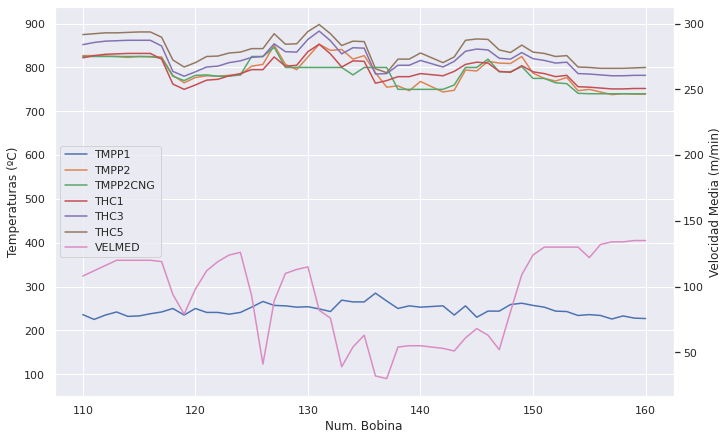

In [ ]:
dibuja_proceso(df_train, pos_ini=110, num_bobs=50)

Ahora mostramos la correlación entre features

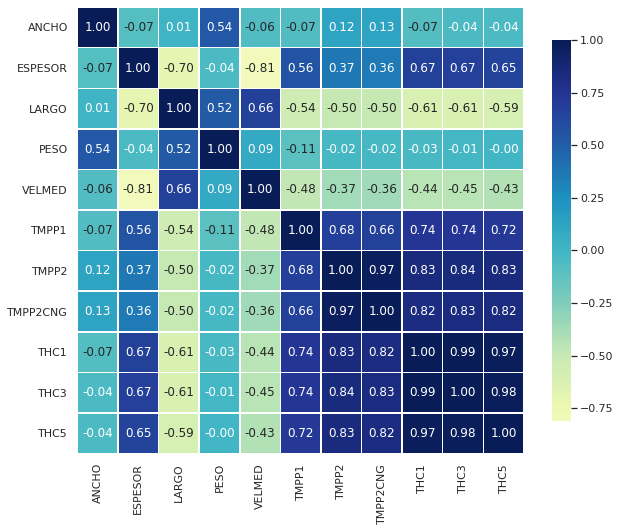

In [ ]:
cols = ['ANCHO', 'ESPESOR', 'LARGO', 'PESO', 'VELMED',
       'TMPP1', 'TMPP2', 'TMPP2CNG', 'THC1', 'THC3', 'THC5']
corr = df_train[cols].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f', square=True,
            linewidths=.5, annot=True, cbar_kws={"shrink":.7},
            cmap="YlGnBu")
#            xticklabels=corr.columns,
#            yticklabels=corr.columns,
#             cmap="YlGnBu")

**EJERCICIO: Usando la gráfica de correlaciones anterior identifica las variables con correlación elevada y explica por qué crees que tienen una correlación tan alta. Incluye el codigo que consideres necesario para justificar las mismas.**

Las temperaturas tienen una correlación muy alta, ya que dentro del mismo horno tienen que haber unas mediciones similares.

Respecto a la velocidad al pasar por las bobinas si entra una lamina con diferente espesor es normal que hasta que se adapte haya una variacion, por eso son muy dependientes la una de la otra. Cambiando el espesor cambia la velocidad, ese es el dato esencial.
El peso con la largura, ancho y espesor, determinana las diemnsiones y la cantidad de masa que tienen las laminas, es normal que esten relacionadas en conjunto con el peso.
Después la TMPP1 esta correlada porque el precalentado tiene que ver mucho con el proceso, además asi se llega antes a las temperaturas objetivo, además de que optimiza la energía que utiliza.

Vamos a dibujar el 'punto de operación' (PE) del proceso. El PE de un proceso o sistema es el estado en el que está el mismo en un momento de terminado. En el caso del proceso de galvanizado correspondería con la medición instantánea de las variables que influyen en el mismo. (velocidades, temperaturas, dimensiones del producto, etc.). De la proyección, vamos a eliminar algunas variables muy correladas entre si.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Seleccionamos variables eliminando aquellas muy correladas o que no explican el PE
cols_pca = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP1', 'TMPP2', 'THC1']

# Estandarizamos todas las columnas
scaler = StandardScaler()
scaler.fit(df_train[cols_pca])
df_train_esc = scaler.transform(df_train[cols_pca])
df_test_esc = scaler.transform(df_test[cols_pca])

# Sacamos los dos primeros componentes PCA para usarlos como ejes x e y
pca = PCA(n_components=2)
pca.fit(df_train_esc)
print('Varianza explicada con los dos ejes:',np.sum(pca.explained_variance_ratio_))

pca = PCA(n_components=3)
pca.fit(df_train_esc)
print('Varianza explicada con los tres ejes:',np.sum(pca.explained_variance_ratio_))

pca = PCA(n_components=4)
pca.fit(df_train_esc)
print('Varianza explicada con los cuatro ejes:',np.sum(pca.explained_variance_ratio_))


Varianza explicada con los dos ejes: 0.7399525120297519
Varianza explicada con los tres ejes: 0.8996042812038992
Varianza explicada con los cuatro ejes: 0.9528683184248524


**EJERCICIO: ¿Son suficientes los dos primeros ejes del PCA según la varianza explicada? ¿Qué opinas?**

Si porque con esas variables en dos ejes representas el 74% (aprox) de los casos, aunque es mucho mejor con 3, ya que se puede representar con tres ejes. Y 3 con tres ejes y un color (4 dimesiones, que aun da mejores resultados)

Text(0.5, 1.0, 'Proyección del Punto de Operación usando PCA')

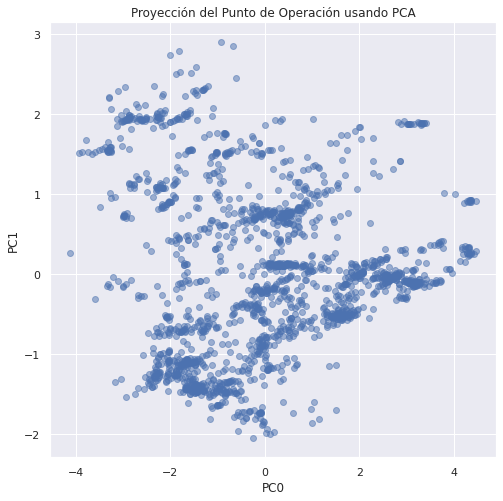

In [ ]:
# Graficamos los puntos de operación proyectados en los dos ejes principales del PCA
proyeccion = pca.transform(df_train_esc)
plt.figure(figsize=(8,8))
plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.50)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Proyección del Punto de Operación usando PCA')

In [ ]:
def saca_flechas(proyeccion, pos_ini=0, nump=10):
    proyec = proyeccion[pos_ini:pos_ini+nump]
    diff_proyec = np.diff(proyec,axis=0)

    plt.figure(figsize=(8,8))
    plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.10)
    plt.xlabel('PC0')
    plt.ylabel('PC1')
    plt.title('Recorrido del Punto de Operación usando PCA')
    for posrow in range(len(diff_proyec)):
        plt.arrow(x=proyec[posrow,0],y=proyec[posrow,1],
                  dx=diff_proyec[posrow,0],dy=diff_proyec[posrow,1],
                  color='red', linewidth=2.0,
                  head_width=0.1, head_length=0.1)

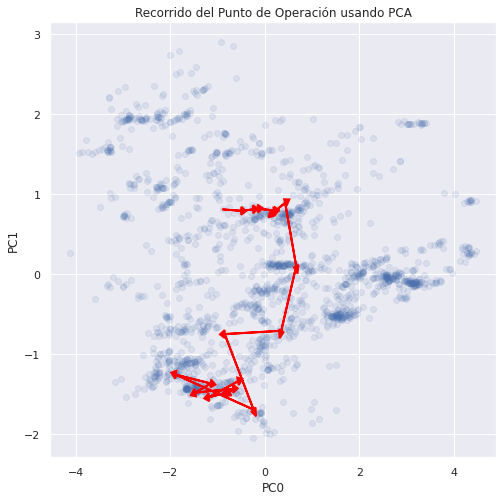

In [ ]:
saca_flechas(proyeccion,pos_ini=1010,nump=20)

**EJERCICIO: Usando las funciones anteriores busca otros dos momentos donde se produzcan cambios bruscos en el punto de operación y muéstralos con la funcion 'saca_flechas()'. Incluye el codigo que consideres necesario para justificar las mismas.**
    

con posicion 130
con posicion 140


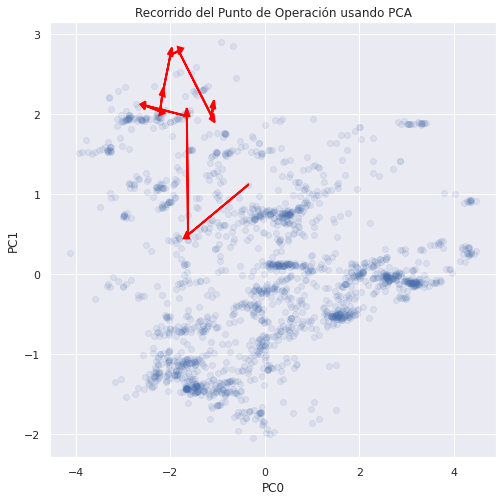

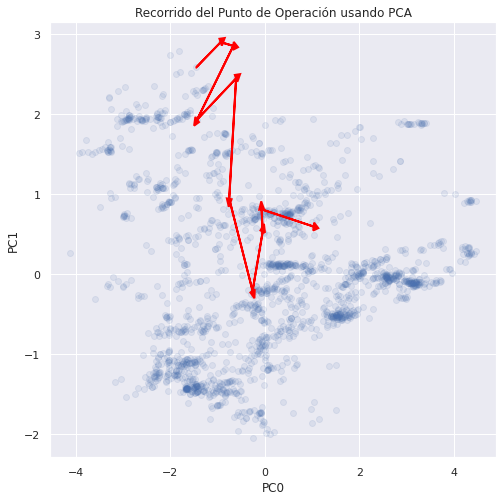

In [ ]:
#primero he realizado un for  i in range(25): y me he dado cuenta que el 140 y el 150 se salen de lo común
for i in [13,14]:
   print("con posicion",i*10)
   saca_flechas(proyeccion, pos_ini=i*10, nump=10)

**EJERCICIO: Crea una nueva función basada en 'saca_flechas()' para poder mostrar los puntos de operación de la base de datos de testeo encima de la proyeccion PCA de los puntos de entrenamiento. ¿Están en una zona diferente? ¿Qué pasaría si es así?**

Text(0.5, 1.0, 'Proyección del Punto de Operación usando PCA')

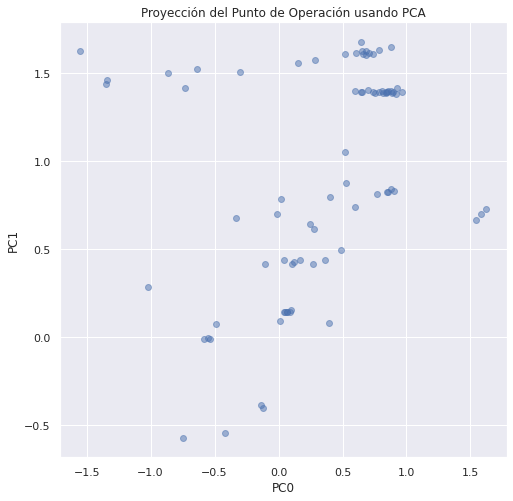

In [ ]:
# Graficamos los puntos de operación proyectados en los dos ejes principales del PCA
proyeccion2 = pca.transform(df_test_esc)
plt.figure(figsize=(8,8))
plt.scatter(proyeccion2[:,0],proyeccion2[:,1],alpha=0.50)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Proyección del Punto de Operación usando PCA')

In [ ]:
def saca_flechas2(proyeccion2,proyeccion, pos_ini=0, nump=10):
    proyec = proyeccion2[pos_ini:pos_ini+nump]
    diff_proyec = np.diff(proyec,axis=0)

    plt.figure(figsize=(8,8))
    plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.10)
    plt.xlabel('PC0')
    plt.ylabel('PC1')
    plt.title('Recorrido del Punto de Operación usando PCA (TEST)')
    for posrow in range(len(diff_proyec)):
        plt.arrow(x=proyec[posrow,0],y=proyec[posrow,1],
                  dx=diff_proyec[posrow,0],dy=diff_proyec[posrow,1],
                  color='green', linewidth=2.0,
                  head_width=0.1, head_length=0.1)

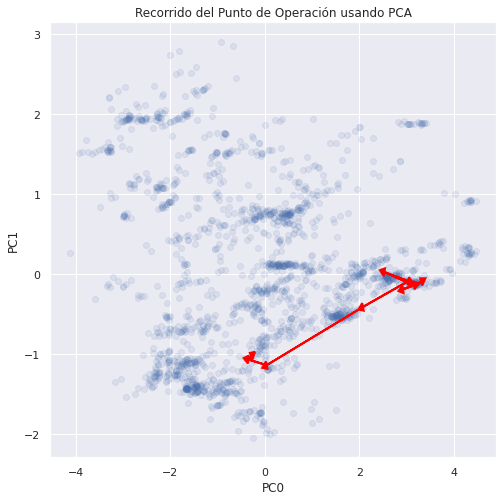

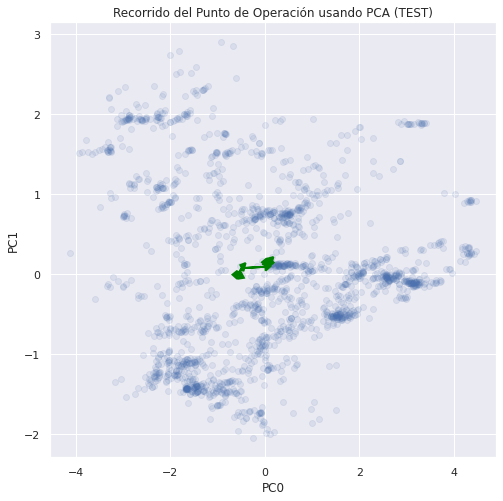

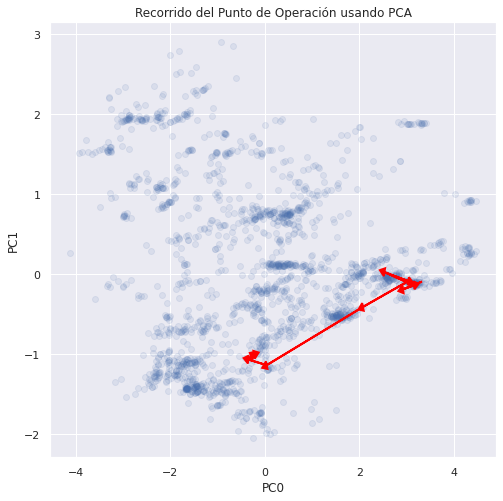

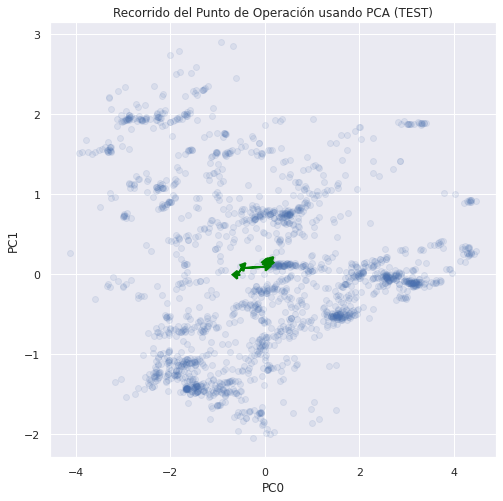

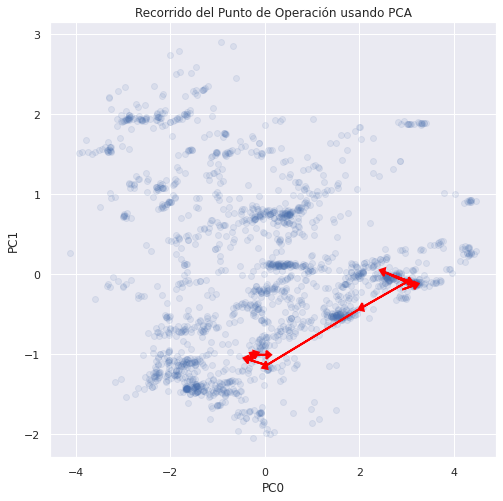

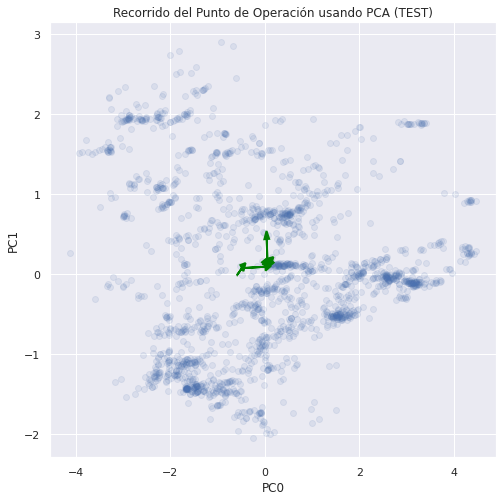

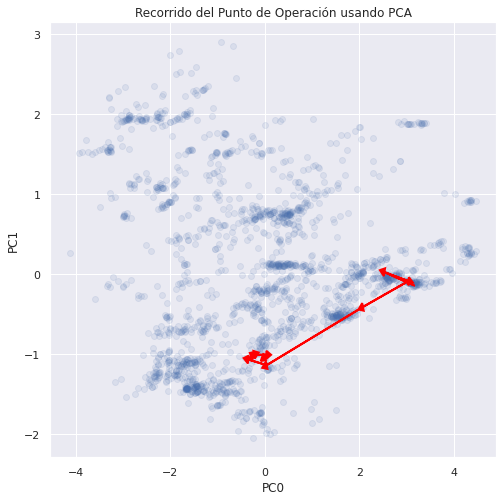

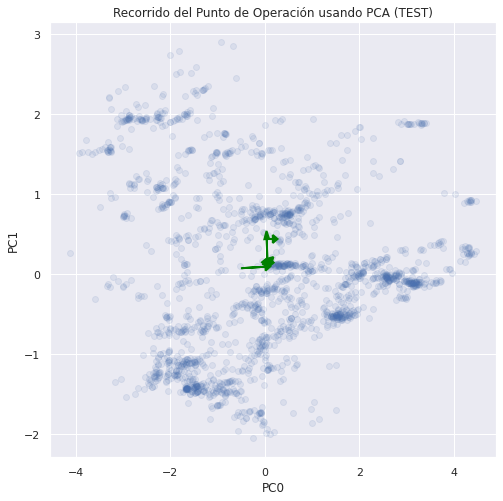

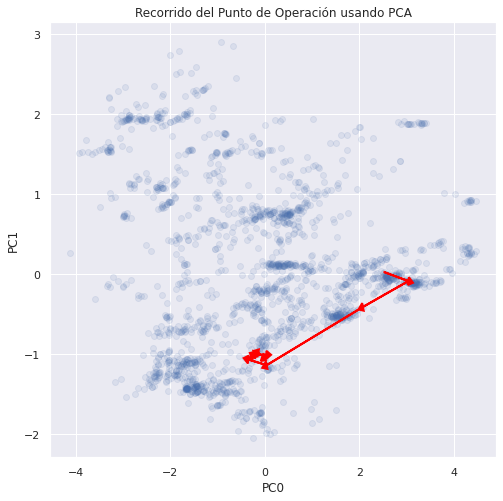

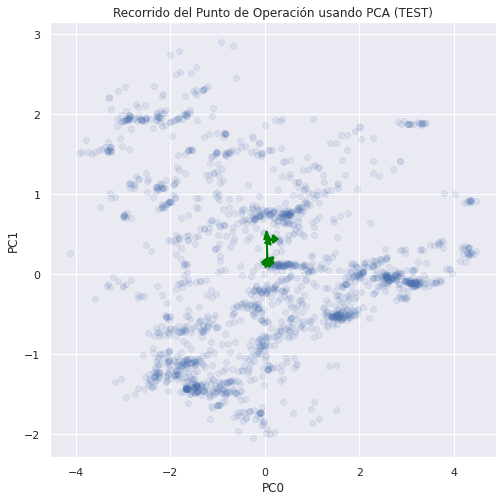

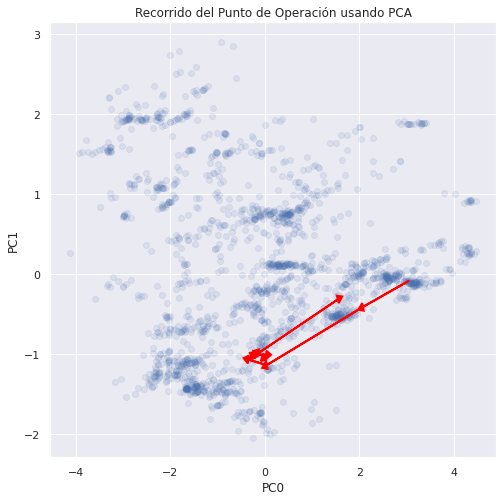

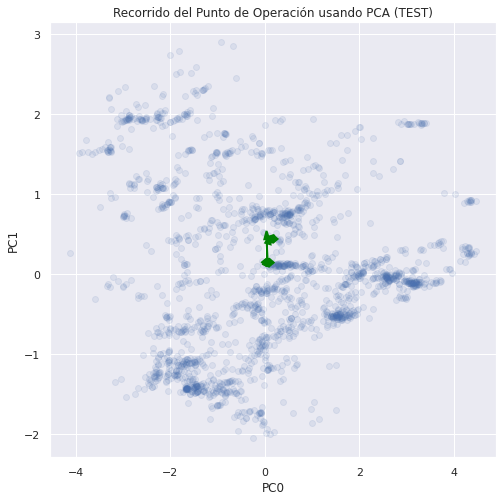

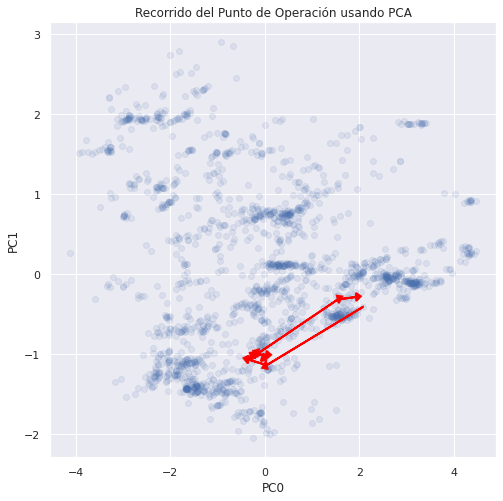

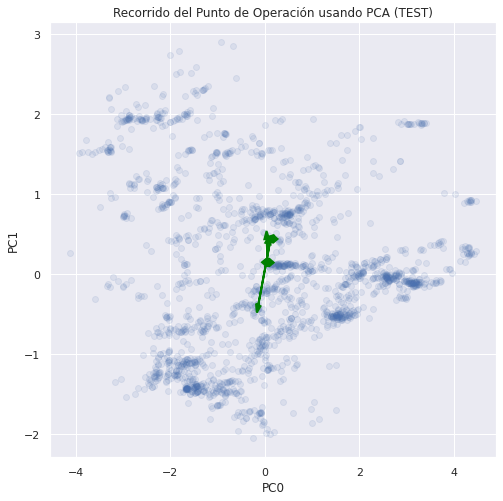

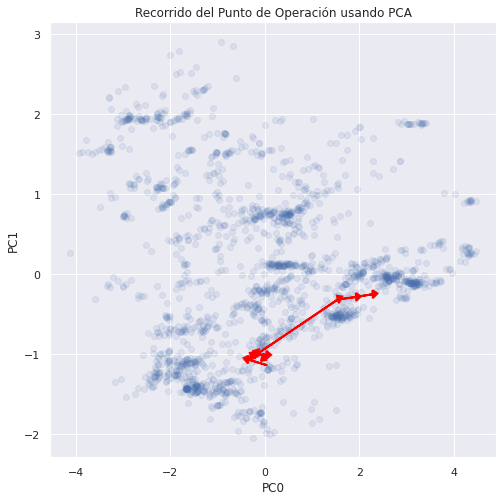

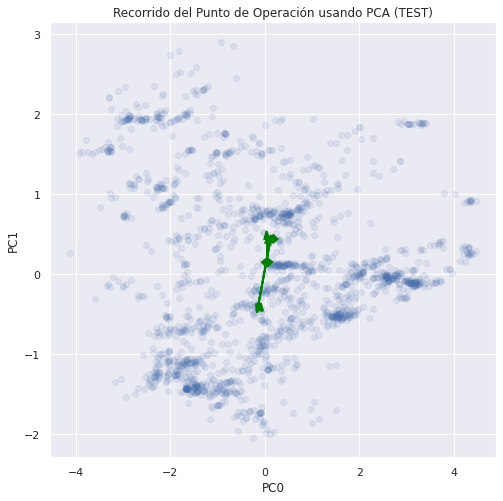

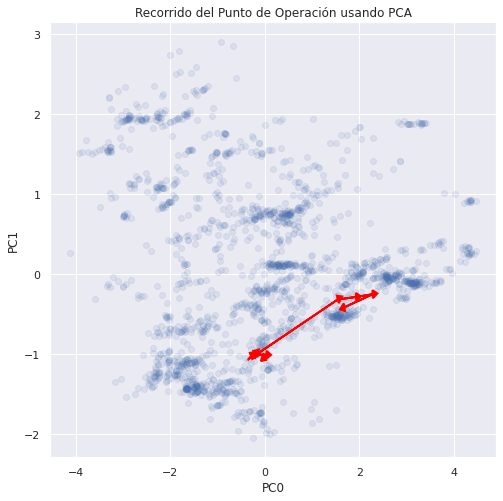

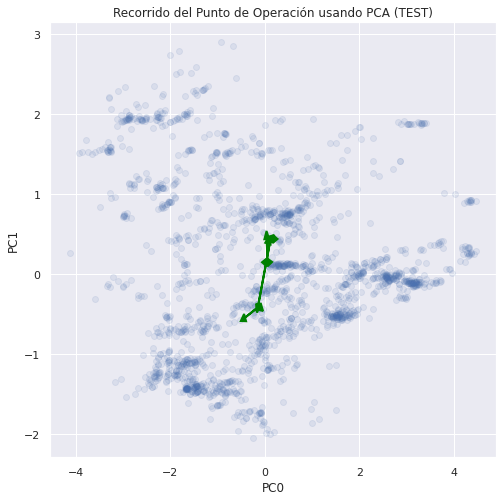

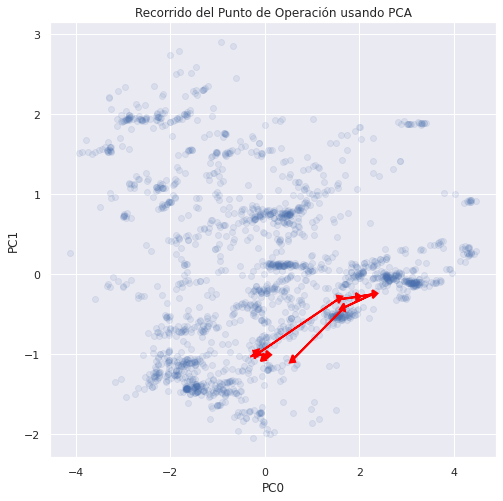

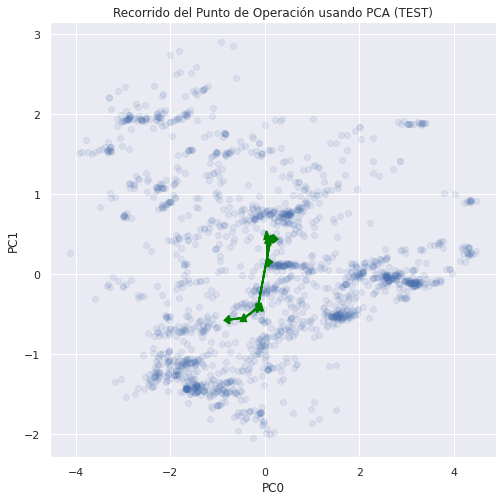

In [ ]:
for i in range(10):
   saca_flechas(proyeccion, pos_ini=i, nump=10)
   saca_flechas2(proyeccion2,proyeccion,pos_ini=i, nump=10)

Si estan en zonas diferentes, porque para mismos valores saca diferentes vectores.


**EJERCICIO: Usa otros tipos de proyecciones (ISOMAP, LLE, MDS, T-SNE, etc.) para visualizar el punto de operación. Mínimo dos!**

In [ ]:
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding

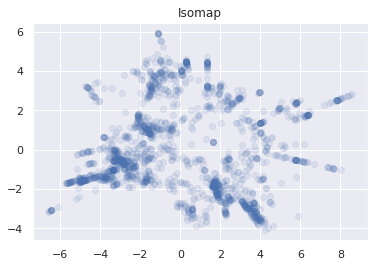

In [ ]:
# Seleccionamos variables eliminando aquellas muy correladas o que no explican el PE
cols_pca = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP1', 'TMPP2', 'THC1']

# Estandarizamos todas las columnas
scaler = StandardScaler()
scaler.fit(df_train[cols_pca])
df_train_esc = scaler.transform(df_train[cols_pca])
df_test_esc = scaler.transform(df_test[cols_pca])

X=df_train_esc
proyeccion=Isomap().fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.10)
plt.title("Isomap")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


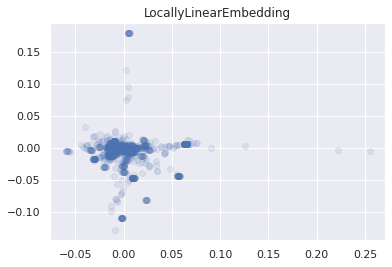

In [ ]:
# Seleccionamos variables eliminando aquellas muy correladas o que no explican el PE
cols_pca = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP1', 'TMPP2', 'THC1']

# Estandarizamos todas las columnas
scaler = StandardScaler()
scaler.fit(df_train[cols_pca])
df_train_esc = scaler.transform(df_train[cols_pca])
df_test_esc = scaler.transform(df_test[cols_pca])

X=df_train_esc
proyeccion=LocallyLinearEmbedding().fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.10)
plt.title("LocallyLinearEmbedding")
plt.show()

# ENTREGA

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.